In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer, FTTransformer
from preprocessing import get_features_and_target

In [10]:
train_df = pd.read_csv("data/train_data.csv")
dev_df = pd.read_csv("data/development_data.csv")

x_train, y_train = get_features_and_target(train_df)
x_dev, y_dev = get_features_and_target(dev_df)

target_column = "PullTest (N)"  


In [11]:
x_train.head()

Pressure (PSI)  Welding Time (ms)  Angle (Deg)  Force (N)  Current (A)  \
0              80                800            0     115.54      2929.03   
1              95                200           15       8.31      1075.09   
2              60               1200            0      97.09      4161.74   
3              60                400            0      93.01      3140.98   
4              80               1000            0      96.29      3615.49   

   Thickness A (mm)  Thickness B (mm)                Material  \
0             0.625             0.631  AISI 1010 carbon steel   
1             0.946             0.939  AISI 1010 carbon steel   
2             0.615             0.619  AISI 1010 carbon steel   
3             0.621             0.632  AISI 1010 carbon steel   
4             0.631             0.640  AISI 1010 carbon steel   

   Thickness A+B (mm)  
0               1.256  
1               1.885  
2               1.234  
3               1.253  
4               1.271

In [12]:
X, y = get_features_and_target(train_df)
num_unique_materials = X["Material"].nunique()
num_cont_features = X.shape[1] - 1



In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['Material'] = le.fit_transform(X['Material'])


In [14]:
sample = X.iloc[0]

# Get the encoded material category value
material_idx = sample["Material"]
x_categ = torch.tensor([[material_idx]], dtype=torch.long)

# Drop the "Material" column to get the continuous features
x_numer = torch.tensor([sample.drop("Material").to_numpy()], dtype=torch.float)

/tmp/ipykernel_219520/1061618069.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x_numer = torch.tensor([sample.drop("Material").to_numpy()], dtype=torch.float)


In [15]:
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
}

In [16]:
model = FTTransformer(
    categories = (num_unique_materials,),  # Only one categorical feature
    num_continuous = num_cont_features,    # Number of continuous columns after preprocessing
    dim = 64,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.9,
    ff_dropout = 0.9
)

x_categ = torch.tensor([[material_idx]], dtype=torch.long)
x_numer = torch.tensor([sample.drop("Material").to_numpy()], dtype=torch.float)



pred = model(x_categ, x_numer) # (1, 1)
print(pred)

tensor([[0.1486]], grad_fn=<AddmmBackward0>)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split
X, y = get_features_and_target(train_df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode Material
le = LabelEncoder()
X_train["Material"] = le.fit_transform(X_train["Material"])
X_val["Material"] = le.transform(X_val["Material"])


In [18]:
from torch.utils.data import Dataset

class WeldingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        x_categ = torch.tensor([row["Material"]], dtype=torch.long)
        x_numer = torch.tensor(row.drop("Material").to_numpy(), dtype=torch.float)
        target = torch.tensor(self.y[idx], dtype=torch.float)
        return x_categ, x_numer, target


In [19]:
from torch.utils.data import DataLoader

train_ds = WeldingDataset(X_train, y_train)
val_ds = WeldingDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


# Not Working

In [ ]:

import torch.nn as nn
import torch.optim as optim

model = FTTransformer(
    categories=(len(le.classes_),),
    num_continuous=X_train.shape[1] - 1,
    dim=128,
    dim_out=1,
    depth=6,
    heads=8,
    attn_dropout=0.9,
    ff_dropout=0.9
)

import plotly.graph_objects as go

train_losses = []
val_losses = []

for epoch in range(10):
    model.train()
    epoch_train_loss = 0
    for x_categ, x_numer, target in train_loader:
        optimizer.zero_grad()
        preds = model(x_categ, x_numer).squeeze()
        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔍 Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for x_categ, x_numer, target in val_loader:
            preds = model(x_categ, x_numer).squeeze()
            loss = criterion(preds, target)
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")



NameError: name 'train_loader' is not defined

In [69]:
import pandas as pd
from preprocessing import get_features_and_target
from sklearn.preprocessing import LabelEncoder
import torch

# Load data
df = pd.read_csv("data/train_data.csv")

# Preprocess
X, y = get_features_and_target(df)

# Encode categorical column
le = LabelEncoder()
X["Material"] = le.fit_transform(X["Material"])

# Prepare tensors
tensor = torch.tensor(X.to_numpy(),dtype=torch.float)
x_categ = torch.tensor(X["Material"].values, dtype=torch.long).unsqueeze(1)  # shape (N, 1)
x_cont = torch.tensor(X.drop("Material", axis=1).values, dtype=torch.float)   # shape (N, num_cont_features)
y_tensor = torch.tensor(y.values, dtype=torch.float)


In [66]:
print(X)

     Pressure (PSI)  Welding Time (ms)  Angle (Deg)  Force (N)  Current (A)  \
0                80                800            0     115.54      2929.03   
1                95                200           15       8.31      1075.09   
2                60               1200            0      97.09      4161.74   
3                60                400            0      93.01      3140.98   
4                80               1000            0      96.29      3615.49   
..              ...                ...          ...        ...          ...   
269              60                600           15      94.39      4167.94   
270              60                800           15      75.04      4022.19   
271              80               1000            0     104.82      3291.78   
272              60                400            0      92.98      3047.60   
273              80                600            0     107.67      3523.46   

     Thickness A (mm)  Thickness B (mm)  Material  

In [73]:
torch.set_printoptions(sci_mode=False, precision=3)
print(tensor)

tensor([[   80.000,   800.000,     0.000,  ...,     0.631,     0.000,
             1.256],
        [   95.000,   200.000,    15.000,  ...,     0.939,     0.000,
             1.885],
        [   60.000,  1200.000,     0.000,  ...,     0.619,     0.000,
             1.234],
        ...,
        [   80.000,  1000.000,     0.000,  ...,     0.624,     0.000,
             1.250],
        [   60.000,   400.000,     0.000,  ...,     0.632,     0.000,
             1.268],
        [   80.000,   600.000,     0.000,  ...,     0.618,     0.000,
             1.241]])


In [65]:
print(x_cont)

tensor([[8.0000e+01, 8.0000e+02, 0.0000e+00,  ..., 6.2500e-01, 6.3100e-01,
         1.2560e+00],
        [9.5000e+01, 2.0000e+02, 1.5000e+01,  ..., 9.4600e-01, 9.3900e-01,
         1.8850e+00],
        [6.0000e+01, 1.2000e+03, 0.0000e+00,  ..., 6.1500e-01, 6.1900e-01,
         1.2340e+00],
        ...,
        [8.0000e+01, 1.0000e+03, 0.0000e+00,  ..., 6.2600e-01, 6.2400e-01,
         1.2500e+00],
        [6.0000e+01, 4.0000e+02, 0.0000e+00,  ..., 6.3600e-01, 6.3200e-01,
         1.2680e+00],
        [8.0000e+01, 6.0000e+02, 0.0000e+00,  ..., 6.2300e-01, 6.1800e-01,
         1.2410e+00]])


In [21]:
from tab_transformer_pytorch import FTTransformer

model = FTTransformer(
    categories=(len(le.classes_),),  # number of unique materials
    num_continuous=x_cont.shape[1],  # number of continuous features
    dim=64,
    dim_out=1,
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1
)



In [22]:
with torch.no_grad():
    pred = model(x_categ, x_cont)
print(pred.shape)

torch.Size([274, 1])


In [23]:
from sklearn.preprocessing import StandardScaler

# Scale target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

In [24]:
from sklearn.preprocessing import StandardScaler

# Scale continuous features
cont_cols = X_train.columns.drop("Material")
scaler_X = StandardScaler()
X_train[cont_cols] = scaler_X.fit_transform(X_train[cont_cols])
X_val[cont_cols] = scaler_X.transform(X_val[cont_cols])
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [25]:
y_scaled = pd.Series(y_scaled, index=y.index)

In [28]:
print(x_cont.shape[1])

8


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import RMSELoss

# Define RMSELoss directly in the notebook to avoid import issues
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yhat, y):
        return torch.sqrt(torch.mean((yhat - y) ** 2))

# Custom Dataset for Tabular Data
class WeldingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        x_categ = torch.tensor([row["Material"]], dtype=torch.long)
        x_numer = torch.tensor(row.drop("Material").to_numpy(), dtype=torch.float)
        target = torch.tensor(self.y.iloc[idx], dtype=torch.float)
        return x_categ, x_numer, target

# Split into train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Datasets and DataLoaders
train_ds = WeldingDataset(X_train, y_train)
val_ds = WeldingDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Model, Loss, Optimizer
model = FTTransformer(
    categories=(1,),
    num_continuous=8,
    dim=8,
    dim_out=1,
    depth=4,
    heads=4,
    attn_dropout=0.3,
    ff_dropout=0.3
)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00025)

#prev lr = 0.01
#dropout prev 0,3

# Training and Validation Loop
num_epochs = 10000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for x_categ, x_numer, target in train_loader:
        optimizer.zero_grad()
        preds = model(x_categ, x_numer).squeeze()
        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for x_categ, x_numer, target in val_loader:
            preds = model(x_categ, x_numer).squeeze()
            loss = criterion(preds, target)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

RuntimeError: Tensor type unknown to einops <class 'pandas.core.frame.DataFrame'>

In [74]:
from sklearn.model_selection import ParameterGrid
import torch
import numpy as np

param_grid = {
    "dim":       [2, 4, 8, 16, 32],
    "depth":     [2, 4, 6],
    "heads":     [2, 4, 8],
    "attn_dropout":[0.1, 0.3],
    "ff_dropout":[0.1, 0.3],
    "lr":        [0.00001, 0.0001, 0.00025, 0.0003],
    "weight_decay":[0, 0.00001]
}

def run_experiment(params, train_loader, val_loader):
    results = []
    for params in ParameterGrid(param_grid):
        # 1) Build model & optimizer
        model = FTTransformer(
            categories=(1,),
            num_continuous=8,
            dim=params["dim"],
            dim_out=1,
            depth=params["depth"],
            heads=params["heads"],
            attn_dropout=params["attn_dropout"],
            ff_dropout=params["ff_dropout"]
        )
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=params["lr"],
            weight_decay=params["weight_decay"]
        )
        criterion = RMSELoss()


    

        #prev lr = 0.01
        #dropout prev 0,3

        # Training and Validation Loop
        num_epochs = 50
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0
            for x_categ, x_numer, target in train_loader:
                optimizer.zero_grad()
                preds = model(x_categ, x_numer).squeeze()
                loss = criterion(preds, target)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
            avg_train_loss = epoch_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            model.eval()
            epoch_val_loss = 0
            
            with torch.no_grad():
                for x_categ, x_numer, target in val_loader:
                    preds = model(x_categ, x_numer).squeeze()
                    loss = criterion(preds, target)
                    epoch_val_loss += loss.item()
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

best_score = float("inf")
best_params = None

for params in ParameterGrid(param_grid):
    val_rmse = run_experiment(params, train_loader, val_loader)
    
    if val_rmse < best_score:
        best_score = val_rmse
        best_params = params

print("Best validation RMSE:", best_score)
print("Best hyperparameters:", best_params)

# 4) Find best combination
best = min(results, key=lambda r: r["val_rmse"])
print("Best params:", best)


Epoch 1 | Train Loss: 2978.1618 | Val Loss: 2925.9756
Epoch 2 | Train Loss: 2977.2548 | Val Loss: 2925.9756
Epoch 3 | Train Loss: 2977.4823 | Val Loss: 2925.9755
Epoch 4 | Train Loss: 2979.6536 | Val Loss: 2925.9752
Epoch 5 | Train Loss: 2981.5666 | Val Loss: 2925.9750
Epoch 6 | Train Loss: 2976.4780 | Val Loss: 2925.9750
Epoch 7 | Train Loss: 2976.6601 | Val Loss: 2925.9747
Epoch 8 | Train Loss: 2979.7238 | Val Loss: 2925.9745
Epoch 9 | Train Loss: 2979.6817 | Val Loss: 2925.9745
Epoch 10 | Train Loss: 2974.0116 | Val Loss: 2925.9741
Epoch 11 | Train Loss: 2979.5204 | Val Loss: 2925.9740
Epoch 12 | Train Loss: 2974.3026 | Val Loss: 2925.9738
Epoch 13 | Train Loss: 2980.2318 | Val Loss: 2925.9738
Epoch 14 | Train Loss: 2977.2890 | Val Loss: 2925.9735
Epoch 15 | Train Loss: 2979.4845 | Val Loss: 2925.9733
Epoch 16 | Train Loss: 2976.8494 | Val Loss: 2925.9731
Epoch 17 | Train Loss: 2976.4948 | Val Loss: 2925.9731
Epoch 18 | Train Loss: 2976.2281 | Val Loss: 2925.9728
Epoch 19 | Train Lo

KeyboardInterrupt: 

In [36]:
print(x_numer)

tensor([[6.0000e+01, 4.0000e+02, 1.5000e+01, 9.5860e+01, 2.9366e+03, 6.3300e-01,
         6.2900e-01, 1.2620e+00],
        [3.5000e+01, 2.0000e+02, 0.0000e+00, 6.5800e+00, 1.1716e+03, 9.3100e-01,
         9.2200e-01, 1.8530e+00],
        [6.0000e+01, 1.0000e+03, 1.5000e+01, 7.3410e+01, 3.5068e+03, 6.4100e-01,
         6.3300e-01, 1.2740e+00],
        [8.0000e+01, 8.0000e+02, 0.0000e+00, 1.1591e+02, 3.4703e+03, 6.3500e-01,
         6.3500e-01, 1.2700e+00],
        [6.0000e+01, 1.0000e+03, 1.5000e+01, 7.9860e+01, 4.0698e+03, 6.1100e-01,
         6.2000e-01, 1.2310e+00],
        [6.0000e+01, 6.0000e+02, 1.5000e+01, 9.4640e+01, 4.2110e+03, 6.1800e-01,
         6.1300e-01, 1.2310e+00],
        [6.0000e+01, 4.0000e+02, 1.5000e+01, 9.5880e+01, 3.0141e+03, 6.3600e-01,
         6.2300e-01, 1.2590e+00],
        [8.0000e+01, 6.0000e+02, 0.0000e+00, 1.0767e+02, 3.5235e+03, 6.2300e-01,
         6.1800e-01, 1.2410e+00],
        [6.0000e+01, 4.0000e+02, 1.5000e+01, 9.5810e+01, 2.6555e+03, 6.2600e-01,

In [78]:
df.head()

Sample ID  Pressure (PSI)  Welding Time (ms)  Angle (Deg)  Force (N)  \
0        101              80                800            0     115.54   
1         31              95                200           15       8.31   
2        493              60               1200            0      97.09   
3        219              60                400            0      93.01   
4         60              80               1000            0      96.29   

   Current (A)  Thickness A (mm)  Thickness B (mm)                Material  \
0      2929.03             0.625             0.631  AISI 1010 carbon steel   
1      1075.09             0.946             0.939  AISI 1010 carbon steel   
2      4161.74             0.615             0.619  AISI 1010 carbon steel   
3      3140.98             0.621             0.632  AISI 1010 carbon steel   
4      3615.49             0.631             0.640  AISI 1010 carbon steel   

   PullTest (N)  NuggetDiameter (mm) Category Comments  Thickness A+B (mm)  
0        2683.1                 3.41     Good      NaN               1.256  
1        2667.3                 2.81      Bad      DOE               1.885  
2        2730.3                 3.58     Good      NaN               1.234  
3        2748.3                 3.38     Good      NaN               1.253  
4        2946.9                 3.73     Good      NaN               1.271

In [81]:
X.head()

Pressure (PSI)  Welding Time (ms)  Angle (Deg)  Force (N)  Current (A)  \
0              80                800            0     115.54      2929.03   
1              95                200           15       8.31      1075.09   
2              60               1200            0      97.09      4161.74   
3              60                400            0      93.01      3140.98   
4              80               1000            0      96.29      3615.49   

   Thickness A (mm)  Thickness B (mm)  Material  Thickness A+B (mm)  
0             0.625             0.631         0               1.256  
1             0.946             0.939         0               1.885  
2             0.615             0.619         0               1.234  
3             0.621             0.632         0               1.253  
4             0.631             0.640         0               1.271

In [74]:
import plotly.graph_objects as go

fig = go.Figure()

# Training loss trace
fig.add_trace(go.Scatter(
    y=train_losses,
    mode="lines+markers",
    name="Train Loss",
    line=dict(color="royalblue", width=2),
    marker=dict(size=4)
))

# Validation loss trace
fig.add_trace(go.Scatter(
    y=val_losses,
    mode="lines+markers",
    name="Validation Loss",
    line=dict(color="tomato", width=2),
    marker=dict(size=4)
))

# Layout
fig.update_layout(
    title="Training & Validation Loss over Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(00, 10000, 500)),  # Show ticks every 100 epochs
        tickfont=dict(size=10)
    ),
    template="plotly_white",
    legend=dict(x=0.05, y= -0.25, bgcolor="rgba(255,255,255,0)", borderwidth=0)
)

fig.show()


In [62]:
import plotly.graph_objects as go

epochs = list(range(1, len(train_losses) + 1))

fig = go.Figure()

# Training loss trace
fig.add_trace(go.Scatter(
    x=epochs,
    y=train_losses,
    mode="lines",
    name="Training Loss",
    line=dict(color="royalblue", width=2)
))

# Validation loss trace
fig.add_trace(go.Scatter(
    x=epochs,
    y=val_losses,
    mode="lines",
    name="Validation Loss",
    line=dict(color="firebrick", width=2, dash="dash")
))

# Layout enhancements
fig.update_layout(
    title="Training & Validation Loss over 100 Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(0, 10000, 500)),  # Show ticks every 100 epochs
        tickfont=dict(size=10)
    ),
    yaxis=dict(
        tickformat=".2e" if max(train_losses + val_losses) > 1e4 else ".4f",  # Dynamic formatting
        gridcolor="lightgray"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template="plotly_white",
    margin=dict(t=60, b=40)
)

fig.show()


In [55]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Collect predictions and true values from the validation set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_categ, x_numer, target in val_loader:
        preds = model(x_categ, x_numer).squeeze().cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(target.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Inverse-transform predictions and targets to original units
preds_orig = scaler_y.inverse_transform(all_preds.reshape(-1, 1)).flatten()
targets_orig = scaler_y.inverse_transform(all_targets.reshape(-1, 1)).flatten()

# Calculate MAE and RMSE in original units
mae = mean_absolute_error(targets_orig, preds_orig)
rmse = np.sqrt(mean_squared_error(targets_orig, preds_orig))

print(f"MAE (original units): {mae:.2f}")
print(f"RMSE (original units): {rmse:.2f}")

MAE (original units): 201.05
RMSE (original units): 342.08


In [ ]:

regressor.fit(X_train, y_train)

predictions = regressor.predict(X_dev)

mse = mean_squared_error(y_dev, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_dev, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

abs_errors = np.abs(predictions - y_dev)
sorted_errors = np.sort(abs_errors)
cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)

plt.figure(figsize=(8, 5))
plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
plt.xlabel('Absolute Error |y_pred - y_true|')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF) of Absolute Errors')
plt.grid(True)
plt.show()

NameError: name 'predictions' is not defined

## Coefficient of Determination (R²)

The coefficient of determination, denoted as $( R^2 )$, is a commonly used metric to evaluate the performance of a regression model. It indicates how well the model explains the variance in the target variable \( y \).

### Definition

The formula for $( R^2 )$ is:

$$
R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}
$$

Where:

- $( SS_{\text{res}} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2)$: Residual Sum of Squares (model error)
-  $(SS_{\text{tot}} = \sum_{i=1}^{n} (y_i - \bar{y})^2)$: Total Sum of Squares (total variance in the data)

### Interpretation

- $( R^2 = 1)$: Perfect prediction – the model explains 100% of the variance in $( y)$
- $( R^2 = 0)$: The model does no better than simply predicting the mean of $( y )$
- $( R^2 < 0 )$: The model performs worse than a constant mean prediction

### Example

In this case, the model achieved an $( R^2 )$ score of **0.61**, which means it explains **61% of the total variance** in the target variable.

This is a moderate-to-good result, indicating that the model captures significant patterns in the data, but there is still room for improvement.

## Mean Squared Error (MSE)

The **Mean Squared Error (MSE)** is a standard regression metric that measures the average of the squared differences between the predicted values and the actual target values.

### Definition

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Where:

- $y_i$: true value  
- $\hat{y}_i$: predicted value  
- $n$: number of samples

### Interpretation

- MSE penalizes larger errors more strongly due to squaring.
- The result is in the **squared unit** of the target variable (e.g., mm², N², €²).
- A **lower MSE** indicates better prediction accuracy.
- Because of squaring, the MSE is sensitive to **outliers**.

### Example

In this case, the model yielded an MSE of **88,837**, which may seem large, but this must be interpreted in the context of the unit and range of the target variable.

## Root Mean Squared Error (RMSE)

The **Root Mean Squared Error (RMSE)** is the square root of the MSE and represents the average prediction error in the same unit as the target variable.

### Definition

$RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 } = \sqrt{MSE}$

### Interpretation

- RMSE is easier to interpret than MSE because it is in the **original unit** of the target variable.
- It gives a direct sense of **how far off predictions are**, on average.
- Like MSE, it is also sensitive to outliers due to the squaring.

### Example

In this case, the RMSE is approximately **298 N**.  
Given that the mean of the target variable (PullTest) is **2953 N**, this corresponds to a **relative prediction error of about 10.1 %**.

This means that, on average, the model's predictions deviate from the true pull test values by approximately 298 N.


In [12]:
results = {}

X_train_new = X_train.drop(columns=["Material", "Category", "Comments"])
X_dev_new = X_dev.drop(columns=["Material", "Category", "Comments"])

for name, model in models.items():
    model.fit(X_train_new, y_train)
    preds = model.predict(X_dev_new)
    
    mse = mean_squared_error(y_dev, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_dev, preds)
    
    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

NameError: name 'models' is not defined

In [29]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(2)
print(results_df)

                     MSE    RMSE    R²
TabPFN          71549.75  267.49  0.69
Decision Tree   81260.90  285.06  0.64
Random Forest   73589.86  271.27  0.68
XGBoost        113405.48  336.76  0.50


In [ ]:
cdf_data = {}  

for name, model in models.items():
    model.fit(X_train_new, y_train)
    preds = model.predict(X_dev_new)
    
    mse = mean_squared_error(y_dev, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_dev, preds)
    
    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }
    
    abs_errors = np.abs(preds - y_dev)
    sorted_errors = np.sort(abs_errors)
    cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    cdf_data[name] = (sorted_errors, cdf)

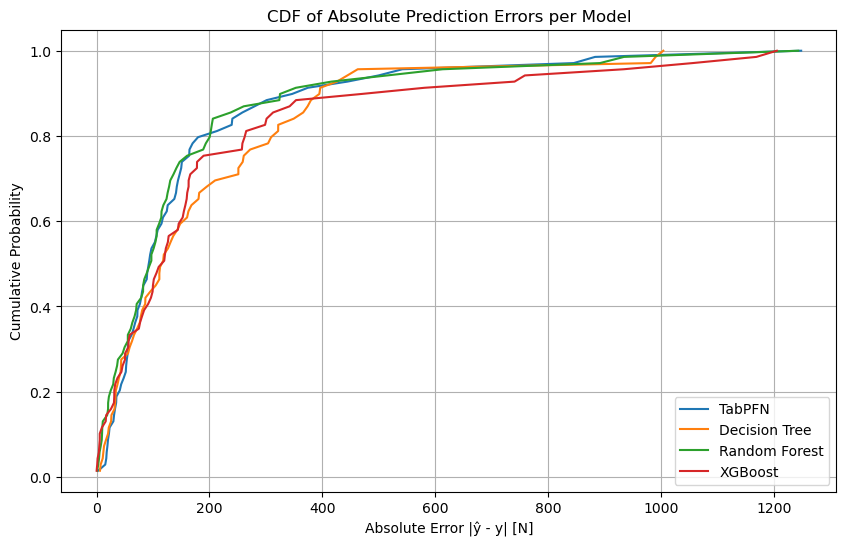

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, (errors, cdf) in cdf_data.items():
    plt.plot(errors, cdf, label=name)

plt.xlabel("Absolute Error |ŷ - y| [N]")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Absolute Prediction Errors per Model")
plt.grid(True)
plt.legend()
plt.show()